## References:
1. [Hugginface](https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-mix)
2. [Sentiment Analysis with BERT](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=PGnlRWvkY-2c)

In [1]:
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
class_names = ['not_sarcastic', 'sarcastic']

In [3]:
path="./"

TypeI=""
TypeII="TweetPreprocessed."
TypeIII="HalfPreprocessed."
TypeIV="FullyPreprocessed."

pathO0="TaskA.Ar.train.NotAugmented."
pathO1="TaskA.Ar.train.Augmented."
pathO2="TaskA.Ar.train.Augmented.NotEmbedding."

pathE0="TaskA.Ar.train.Augmented.NotBalanced."
pathE1="TaskA.Ar.train.Augmented.Balanced.Original."
pathE2="TaskA.Ar.train.Augmented.Balanced.NotOriginal."
pathE3="TaskA.Ar.train.Augmented.Balanced.NotOriginal.NotEmbedding."


pathB0="TaskA.Ar.train.Augmented.Biased0.Original."
pathB1="TaskA.Ar.train.Augmented.Biased1.Original."
pathB2="TaskA.Ar.train.Augmented.Biased2.Original."
pathB3="TaskA.Ar.train.Augmented.Biased3.Original."
pathB4="TaskA.Ar.train.Augmented.Biased4.Original."
pathB5="TaskA.Ar.train.Augmented.Biased5.Original."
pathB6="TaskA.Ar.train.Augmented.Biased6.Original."
pathB7="TaskA.Ar.train.Augmented.Biased7.Original."
pathB8="TaskA.Ar.train.Augmented.Biased8.Original."
pathB9="TaskA.Ar.train.Augmented.Biased9.Original."

pathVal="TaskA.Ar.Basic.Val."
pathTest="TaskA.Ar.Basic.Test."

In [4]:
chosenPath=pathB2
ChosenType=TypeII
print(chosenPath)
print(ChosenType)

df_train = pd.read_csv(path + chosenPath + ChosenType + "csv")
df_train.dropna(subset = ["tweet","sarcastic"], inplace=True)
df_val = pd.read_csv(path + pathVal + ChosenType + "csv")
df_val.dropna(subset = ["tweet","sarcastic"], inplace=True)
df_test = pd.read_csv(path + pathTest + ChosenType + "csv")
df_test.dropna(subset = ["tweet","sarcastic"], inplace=True)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

TaskA.Ar.train.Augmented.Biased2.Original.
TweetPreprocessed.
(5254, 5)
(1241, 5)
(1400, 5)


In [5]:
df_train

,tweet_id,tweet,sarcastic,rephrase,dialect
0,435,كان من الرائع اكتشاف امريكا ولكن كان اروع لو ل...,1,امريكا تشكل خطرا كبيرا على جميع الشعوب بما فيه...,msa
1,1268,كان رجل مسن منحني الظهر يسيرُ في الطريق .. فقا...,1,NaN,msa
2,4137,"""يا جماعه هذا بوكيمون ماحدا عرف يصطاده ويطعميه...",1,NaN,levant
3,4984,اسلحه امريكيه يمتلكها حزب الله المجوسي من اي...,0,NaN,msa
4,2036,"""RT @USER | تبا جدار الصامتين ...",0,NaN,msa
...,...,...,...,...,...
5249,181,بمناسبة إنّي مروحة قريبًا،مافيش حدّ يعرف وين ي...,0,NaN,levant
5250,4983,لا لا ... سبعة ضيف عليهم السويد وهولاندا ويط...,1,NaN,msa
5251,327,"""RT @USER فيصل القاسم: بشار الأسد مستعد لبيع أ...",1,NaN,msa
5252,2972,"قوات الأمن المصرية تقوم بضبط ""لاب توب"" يحوي أغ...",1,NaN,msa


In [6]:
df_val

,tweet_id,tweet,sarcastic,rephrase,dialect
0,2155,مراسل الميادين :جثث المختطفين خالية الاحشاء ...,0,NaN,msa
1,1095,السعودية الرياض مكة المدينة الدرعية صورة ...,0,NaN,msa
2,1624,الأسواني:اذا لم تتوحد القوى الوطنية فورا من أج...,0,NaN,msa
3,2434,تنور !,0,NaN,nile
4,2597,خلق جميل الشعور بالغير,0,NaN,msa
...,...,...,...,...,...
1236,2082,:small_blue_diamond:الثقافة القرآنية:radio_bu...,0,NaN,msa
1237,777,ستبدأ بعد ساعه ونصف اول مناظره بين المرشحان ل...,0,NaN,msa
1238,2977,ميسي يرفض مصافحة مدرب باريس سان جيرمان بعد است...,0,NaN,nile
1239,2753,العنف والقتل في محيط مقر جماعة الإخوان مدان وم...,0,NaN,msa


In [7]:
df_test

,tweet_id,tweet,sarcastic,rephrase,dialect
0,NaN,نتغير من الأفعال مانتغير من مزاجنا,0,NaN,gulf
1,NaN,هل هُناك صباح الخير بطريقة مختلفة؟,0,NaN,nile
2,NaN,الهدرة عليا و المعاني على جارتي,1,NaN,magreb
3,NaN,اللهم إني أسألك حبَّكَ وحبَّ من يحبُّكَ وحبَّ ...,0,NaN,msa
4,NaN,انسى الحياة والدنيا دى وتعالى نهرب منهم,0,NaN,nile
...,...,...,...,...,...
1395,NaN,ياا عمريي صوت بنتهاا تهببلل,0,NaN,levant
1396,NaN,خنفسة شافت ولادها عالحيط قالت ده لولي وملضوم ف...,1,NaN,nile
1397,NaN,يكذب بكل ثقه بالرغم من وضوح كذبه,0,NaN,nile
1398,NaN,بس أنت المهم عندي .,0,NaN,nile


train total 5254 sarcastic 3436 non sarcastic 1818


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


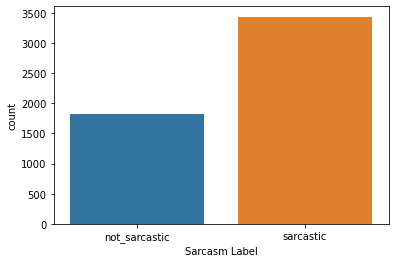

In [8]:
ax = sns.countplot(df_train.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
s_t = 0
ns_t =0
for i in df_train.sarcastic:
    if i == 1:
        s_t+=1
    else:
        ns_t+=1
l_count = len(df_train.sarcastic)
print("train total", l_count, "sarcastic", s_t, "non sarcastic", ns_t)

Val total 1241 sarcastic 298 non sarcastic 943


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


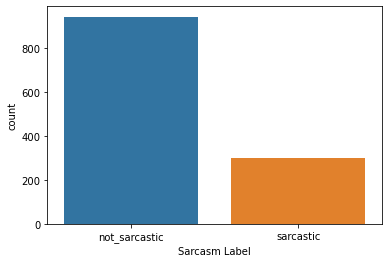

In [9]:
ax = sns.countplot(df_val.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names);
s_t = 0
ns_t =0
for i in df_val.sarcastic:
    if i == 1:
        s_t+=1
    else:
        ns_t+=1
l_count = len(df_val.sarcastic)
print("Val total", l_count, "sarcastic", s_t, "non sarcastic", ns_t)

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


test total 1400 sarcastic 200 non sarcastic 1200


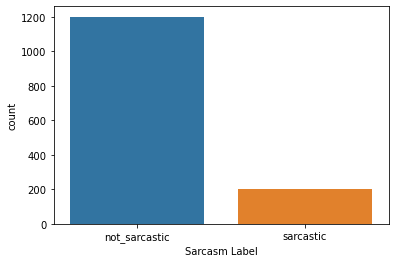

In [10]:
ax = sns.countplot(df_test.sarcastic)
s_t = 0
ns_t =0
for i in df_test.sarcastic:
    if i == 1:
        s_t+=1
    else:
        ns_t+=1
l_count = len(df_test.sarcastic)
print("test total", l_count, "sarcastic", s_t, "non sarcastic", ns_t)
plt.xlabel('Sarcasm Label')

ax.set_xticklabels(class_names);

In [11]:
PRE_TRAINED_MODEL_NAME = 'CAMeL-Lab/bert-base-arabic-camelbert-mix'
bertweet = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, normalization=True)

In [13]:
MAX_LEN = 100

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [14]:
class GPTweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [15]:
df_train.shape, df_val.shape, df_test.shape

((5254, 5), (1241, 5), (1400, 5))

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPTweetDataset(
    tweets=df.tweet.to_numpy(),
    targets=df.sarcastic.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [17]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [19]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [20]:
class SarcasmClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SarcasmClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [21]:
model = SarcasmClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) 
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [23]:
print(input_ids.shape)
print(attention_mask.shape)
F.softmax(model(input_ids, attention_mask), dim=1)

torch.Size([16, 100])
torch.Size([16, 100])


tensor([[0.3031, 0.6969],
        [0.4864, 0.5136],
        [0.3843, 0.6157],
        [0.5242, 0.4758],
        [0.5511, 0.4489],
        [0.5053, 0.4947],
        [0.5933, 0.4067],
        [0.3430, 0.6570],
        [0.5020, 0.4980],
        [0.5766, 0.4234],
        [0.4003, 0.5997],
        [0.5064, 0.4936],
        [0.4840, 0.5160],
        [0.4907, 0.5093],
        [0.4360, 0.5640],
        [0.5195, 0.4805]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [24]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#weights = [float(ns_t)/(s_t+ns_t),1.2*float(s_t)/(s_t+ns_t)] #as class distribution
#class_weights = torch.FloatTensor(weights).cuda()
#loss_fn = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to(device)
loss_fn = nn.CrossEntropyLoss().to(device)#CrossEntropyLoss() has already included a softmax layer inside.

In [25]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
      )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
      )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
  

Epoch 1/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.4189098181152054 accuracy 0.819375713741911


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Val   loss 0.3209552365617874 accuracy 0.8605962933118453

Epoch 2/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.19495696181892827 accuracy 0.9335744194899125


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 0.5999170479555733 accuracy 0.8251410153102336

Epoch 3/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Train loss 0.0697325078578026 accuracy 0.9809668823753331


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Val   loss 1.259952497235738 accuracy 0.7888799355358581

Epoch 4/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Train loss 0.02954963410261606 accuracy 0.9918157594213933


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 1.280138632527292 accuracy 0.8114423851732473

Epoch 5/5
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

Train loss 0.011218351240217294 accuracy 0.9973353635325467


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val   loss 1.1859402842732005 accuracy 0.830781627719581

CPU times: user 2min 21s, sys: 5.82 s, total: 2min 27s
Wall time: 2min 30s


## Evaluation

In [28]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

0.645

In [29]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [30]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [31]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.9542    0.8165    0.8800       943
    sarcastic     0.6014    0.8758    0.7131       298

     accuracy                         0.8308      1241
    macro avg     0.7778    0.8462    0.7966      1241
 weighted avg     0.8694    0.8308    0.8399      1241



In [32]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'

In [33]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.9607    0.6108    0.7468      1200
    sarcastic     0.2669    0.8500    0.4062       200

     accuracy                         0.6450      1400
    macro avg     0.6138    0.7304    0.5765      1400
 weighted avg     0.8616    0.6450    0.6982      1400

